In [87]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.corpus import words
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import scipy as sp

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import model_selection
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

In [2]:
PATH = 'SMSSpamCollection.txt'
MAPPING = {'spam': 1, 'ham': 0}

In [3]:
data = pd.read_csv(PATH, sep='\t', names=['label', 'text'])

In [4]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
## describe data
data.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [6]:
# mapping to int label
data['spam'] = data['label'].map(MAPPING).astype(int)

# length of text
data['length'] = data['text'].apply(len)

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

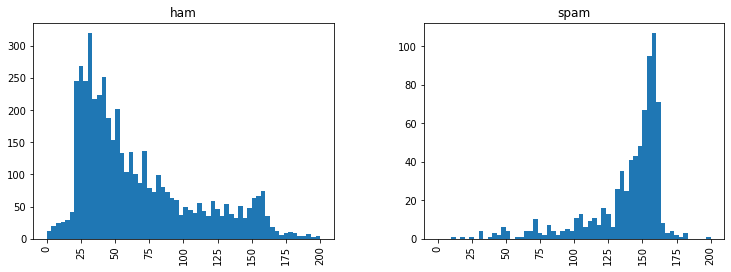

In [7]:
data.hist(column='length',by='label',bins=60,figsize=(12,4), range=(0, 200))

 Bulk of ham has length below 100, for spam it is above 100.

In [8]:
punctuations = list(string.punctuation)
stopwords_list = set(stopwords.words("english"))
valid_words = set(words.words())

In [9]:
def count_list_words(tokens:list, list_words:list):
    counter = 0
    for word in tokens:
        if word in list_words:
            counter+=1
    return counter

In [10]:
def count_punct(string:str, punctuations=punctuations):
    counter = Counter(string)
    return sum([v for k, v in counter.items() if k in punctuations])

In [11]:
data['stopwords_count'] = data['text'].apply(lambda x: count_list_words(x.split(), stopwords_list))
data['valid_words_count'] = data['text'].apply(lambda x: count_list_words(x.split(), valid_words))
data['punct_count'] = data['text'].apply(count_punct)

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

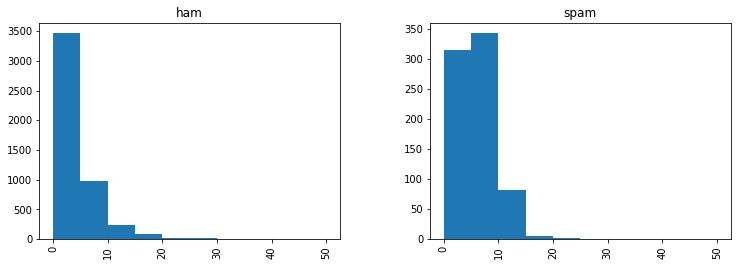

In [12]:
data.hist(column='punct_count',by='label',figsize=(12,4), range=(0, 50))

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

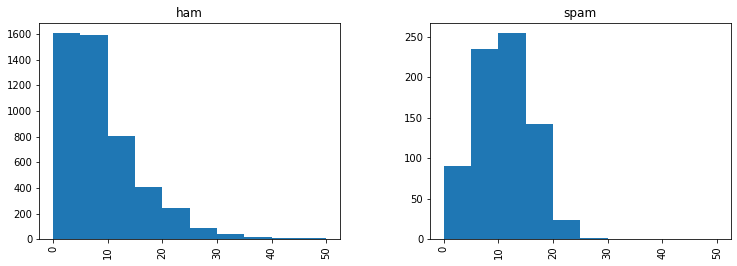

In [13]:
data.hist(column='valid_words_count',by='label',figsize=(12,4), range=(0, 50))

`punct_count` and `valid_words_count` seems like good features

In [39]:
tfidf = TfidfVectorizer(stop_words='english' , min_df=10)
max_scaler = MaxAbsScaler()

In [22]:
train, test = train_test_split(data, test_size=0.3)

In [24]:
tfidf.fit_transform(train['text'])

<3900x620 sparse matrix of type '<class 'numpy.float64'>'
	with 17956 stored elements in Compressed Sparse Row format>

In [65]:
X_train = sp.sparse.hstack((tfidf.fit_transform(train['text']),train[['length','punct_count', 'valid_words_count']].values),format='csr')
X_test = sp.sparse.hstack((tfidf.transform(test['text']),test[['length','punct_count', 'valid_words_count']].values),format='csr')

X_columns=tfidf.get_feature_names()+['length','punct_count', 'valid_words_count']

In [66]:
X_train = max_scaler.fit_transform(X_train)
X_test = max_scaler.transform(X_test)

In [67]:
y_train = train['spam']
y_test = test['spam']

In [68]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3900, 623) (1672, 623) (3900,) (1672,)


In [69]:
models = [
    ('MNB', MultinomialNB()),
    ('KN', KNeighborsClassifier()),
    ('GB', GradientBoostingClassifier()),
    ('SGD', SGDClassifier()),
    ('SVC', SVC())
        ]

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
target_names = ['ham', 'spam']

In [70]:
y_test.shape

(1672,)

In [74]:
results = []
names = []
dfs = []

for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=45)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)

MNB
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1467
        spam       0.92      0.89      0.91       205

    accuracy                           0.98      1672
   macro avg       0.95      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672

KN
              precision    recall  f1-score   support

         ham       0.94      0.99      0.96      1467
        spam       0.91      0.52      0.66       205

    accuracy                           0.93      1672
   macro avg       0.92      0.76      0.81      1672
weighted avg       0.93      0.93      0.93      1672

GB
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1467
        spam       0.98      0.82      0.89       205

    accuracy                           0.98      1672
   macro avg       0.98      0.91      0.94      1672
weighted avg       0.98      0.98      0.98      1672

SGD
     

In [77]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

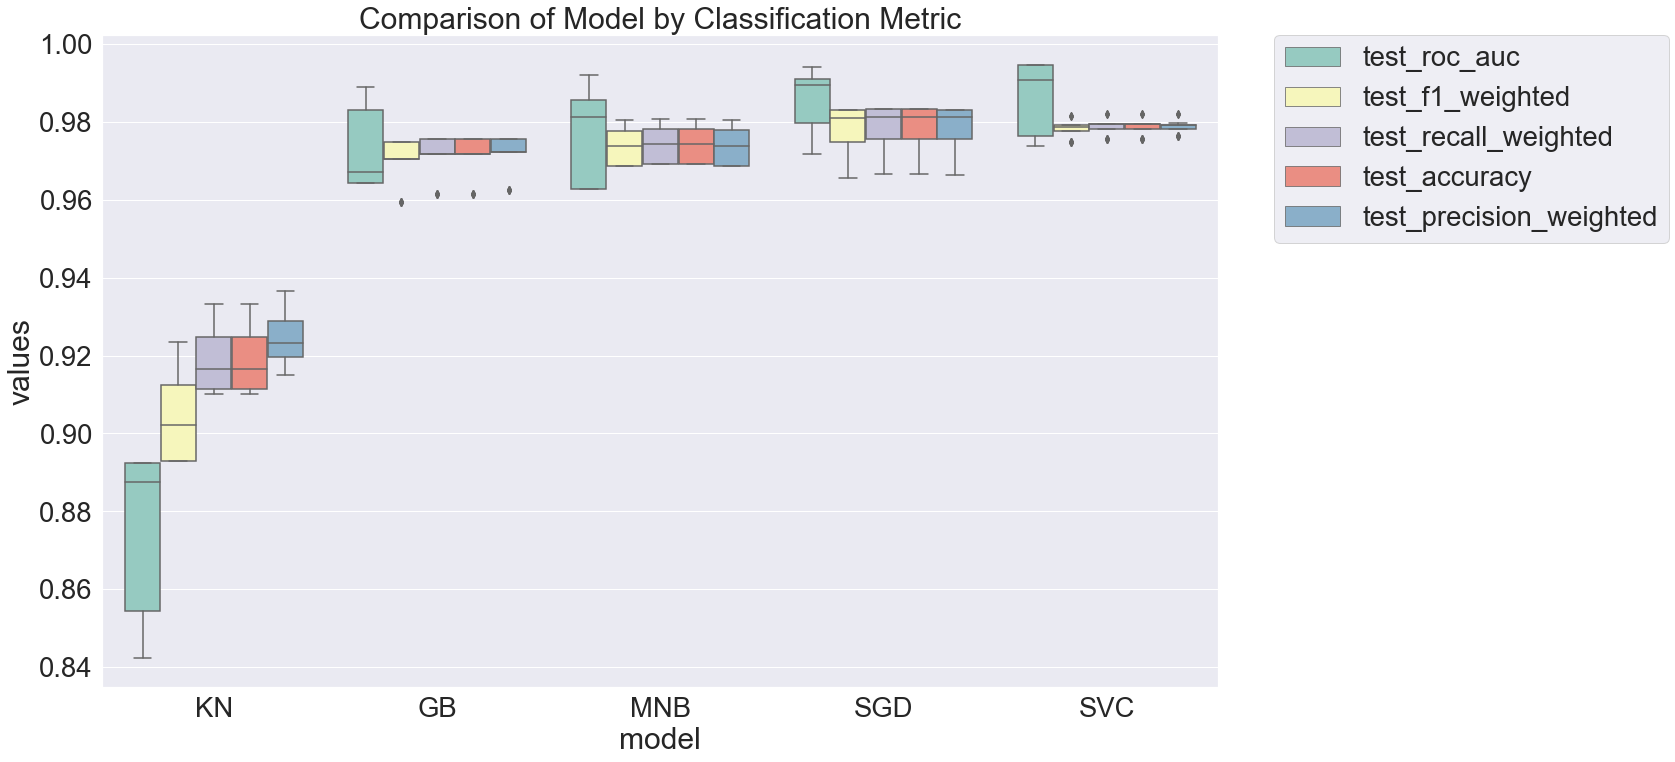

In [78]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

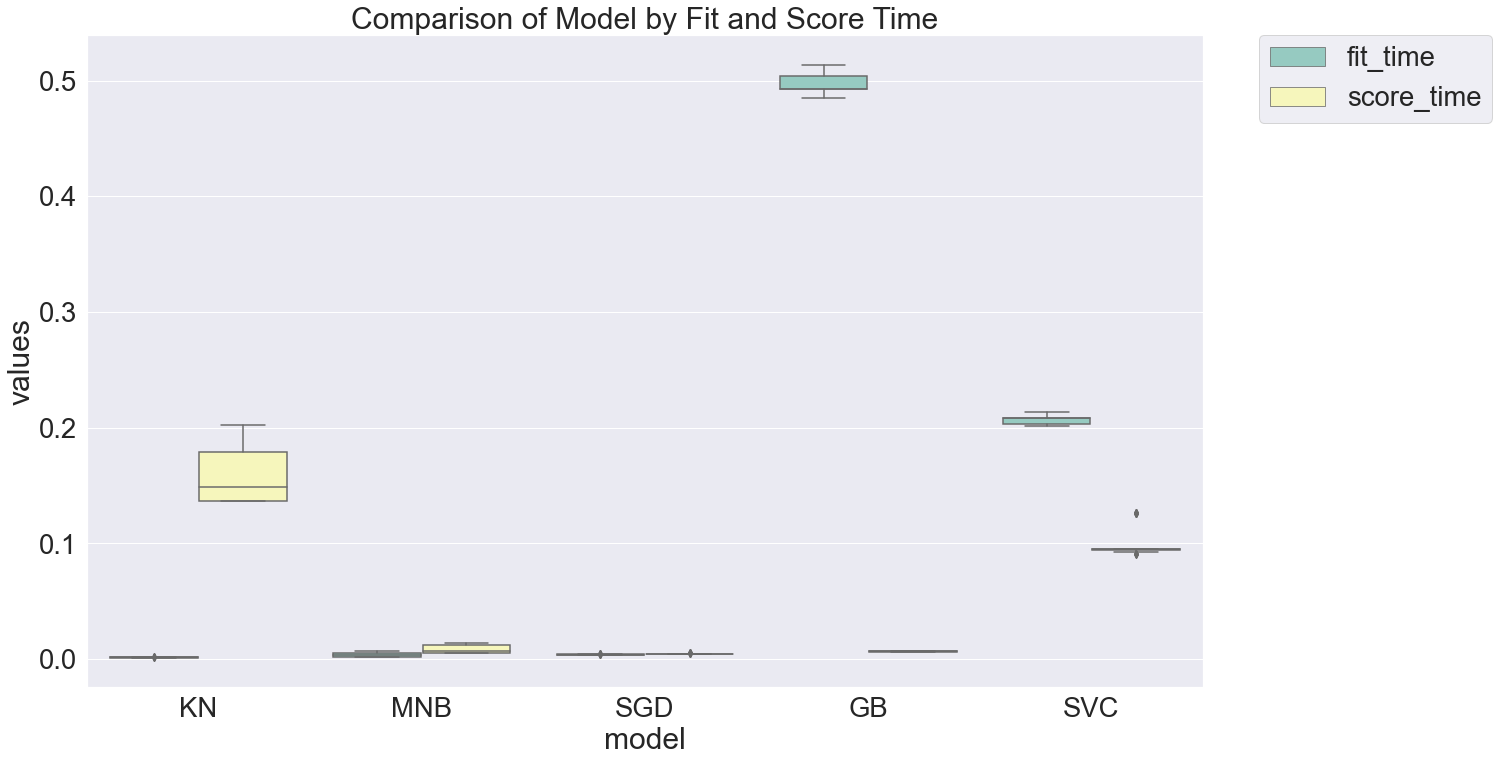

In [81]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [84]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_roc_auc           test_precision_weighted            \
               std      mean                     std      mean   
model                                                            
GB        0.009524  0.972515                0.005094  0.971416   
KN        0.021575  0.875522                0.006580  0.924434   
MNB       0.011338  0.977902                0.004571  0.974456   
SGD       0.007220  0.986873                0.004755  0.979521   
SVC       0.008811  0.985646                0.001697  0.978661   

      test_recall_weighted           test_accuracy           test_f1_weighted  \
                       std      mean           std      mean              std   
model                                                                           
GB                0.005517  0.970983      0.005517  0.970983         0.006036   
KN                0.008190  0.918590      0.008190  0.918590         0.011364   
MNB               0.004433  0.974786      0.004433  0.974786         0.004486   
SGD               0.004746  0.979658      0.004746  0.979658         0.005014   
SVC               0.001932  0.978547      0.001932  0.978547         0.002106   

                 
           mean  
model            
GB     0.969720  
KN     0.903706  
MNB    0.974281  
SGD    0.979226  
SVC    0.977977

# Using SMOTE for class imbalance

In [95]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'shape before: \n{y_train.value_counts()} \n shape after \n{y_train_smote.value_counts()}')

shape before: 
0    3358
1     542
Name: spam, dtype: int64 
 shape after 
1    3358
0    3358
Name: spam, dtype: int64


In [97]:
models = [
    ('MNB_smote', MultinomialNB()),
    ('KN_smote', KNeighborsClassifier()),
    ('GB_smote', GradientBoostingClassifier()),
    ('SGD_smote', SGDClassifier()),
    ('SVC_smote', SVC())
        ]

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
target_names = ['ham', 'spam']

In [98]:
results = []
names = []
dfs = []

for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=45)
        cv_results = model_selection.cross_validate(model, X_train_smote, y_train_smote, cv=kfold, scoring=scoring)
        clf = model.fit(X_train_smote, y_train_smote)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)

MNB_smote
              precision    recall  f1-score   support

         ham       0.99      0.96      0.98      1467
        spam       0.78      0.94      0.85       205

    accuracy                           0.96      1672
   macro avg       0.89      0.95      0.91      1672
weighted avg       0.97      0.96      0.96      1672

KN_smote
              precision    recall  f1-score   support

         ham       1.00      0.78      0.88      1467
        spam       0.39      0.99      0.56       205

    accuracy                           0.81      1672
   macro avg       0.69      0.88      0.72      1672
weighted avg       0.92      0.81      0.84      1672

GB_smote
              precision    recall  f1-score   support

         ham       0.99      0.97      0.98      1467
        spam       0.81      0.90      0.85       205

    accuracy                           0.96      1672
   macro avg       0.90      0.93      0.91      1672
weighted avg       0.96      0.96      0.96   

In [99]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

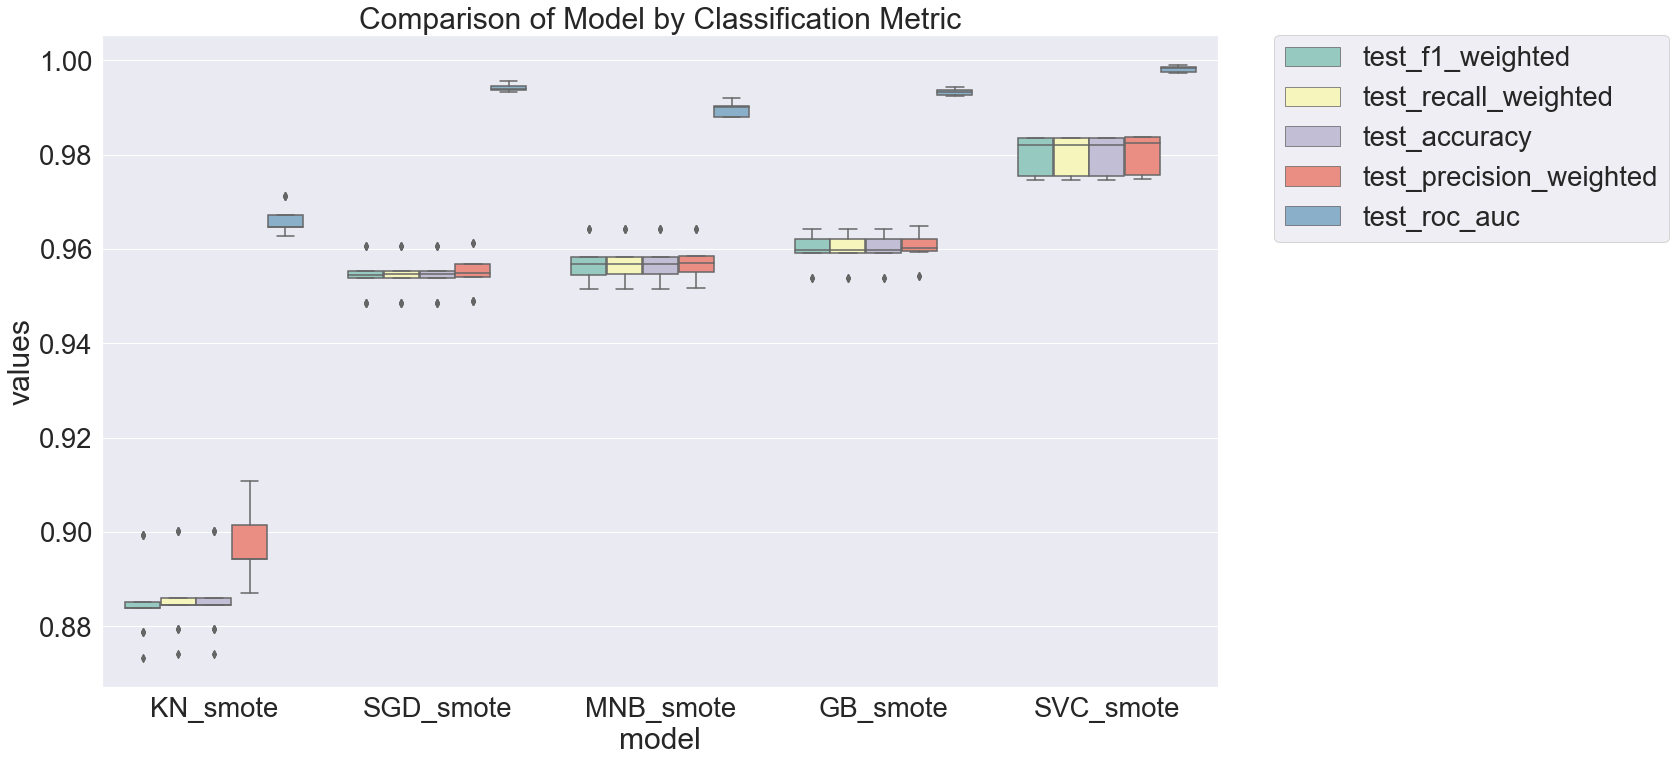

In [100]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

# Verdict
**SVC with SMOTE** gives a better result